# Fitting Functional Response Models in R

Imports:

In [16]:
suppressMessages(library(tidyverse))
suppressMessages(library(plyr))

Load and view data:

In [17]:
FRData <- read.csv("../Data/CRat_prepped.csv", stringsAsFactors = FALSE)
head(FRData)

,ID,ResDensity,N_TraitValue,ResDensityUnit,TraitUnit
,<int>,<dbl>,<dbl>,<chr>,<chr>
1,39835,10,0.001205546,Individuals per arena,Individual/(Individual*120 mins)
2,39835,10,0.001064899,Individuals per arena,Individual/(Individual*120 mins)
3,39835,10,0.001205546,Individuals per arena,Individual/(Individual*120 mins)
4,39835,25,0.002561778,Individuals per arena,Individual/(Individual*120 mins)
5,39835,25,0.002411097,Individuals per arena,Individual/(Individual*120 mins)
6,39835,25,0.002009236,Individuals per arena,Individual/(Individual*120 mins)


Take a subset to use as an example:

In [21]:
df <- subset(FRData, ID == 140)

# Explanatory and response vars
x <- df$ResDensity
y <- df$N_TraitValue

[1] 0.0429 0.1572 0.2360 0.0816 0.2495 0.1213

## Linear models
### Quadratic polynomial
$$
    f(R) = a+bx+cx^2
$$

### Cubic polynomial
$$
    f(R) = a+bx+cx^2+dx^3
$$

### Holling I
$$
    f(R) = aR
$$
Where:
* f = consumption rate
* a = attack rate
* R = resourse density

#### Fit:

In [31]:
# Quadratic polynomial
Quad <- lm(y ~ poly(y, 2))

# Cubic polynomial
Cube <- lm(x ~ poly(y, 3))

#### Calculate AIC/BIC values:

In [22]:
FitStats <- list(QuadAIC = AIC(Quad), CubeAIC = AIC(Cube), QuadBIC = BIC(Quad), CubeBIC = BIC(Cube))
FitStats

$QuadAIC
[1] -32.56417

$CubeAIC
[1] -31.67572

$QuadBIC
[1] -33.39713

$CubeBIC
[1] -32.71692

## Non-linear models

### Holling II
$$
    f(R) = \frac{aR}{1+ahR}
$$
Where:
* f = *per capita* consumption rate
* R = resource density
* a = attack rate (instantaneous rate of discovery) — Holling, 1959b
* h = handling time

### Holling III
$$
    f(R) = \frac{aR^{q + 1}}{1 + ahR^{q + 1}}
$$
Where:
* f = *per capita* consumption rate
* R = resource density
* a = attack rate
* h = handling time
* q = shape parameter that allows the shape of the response to be more flexible/variable (thus making this model more phenomenological).

### Start values
Let's visualise the problem with a plot

In [5]:
library(ggplot2)

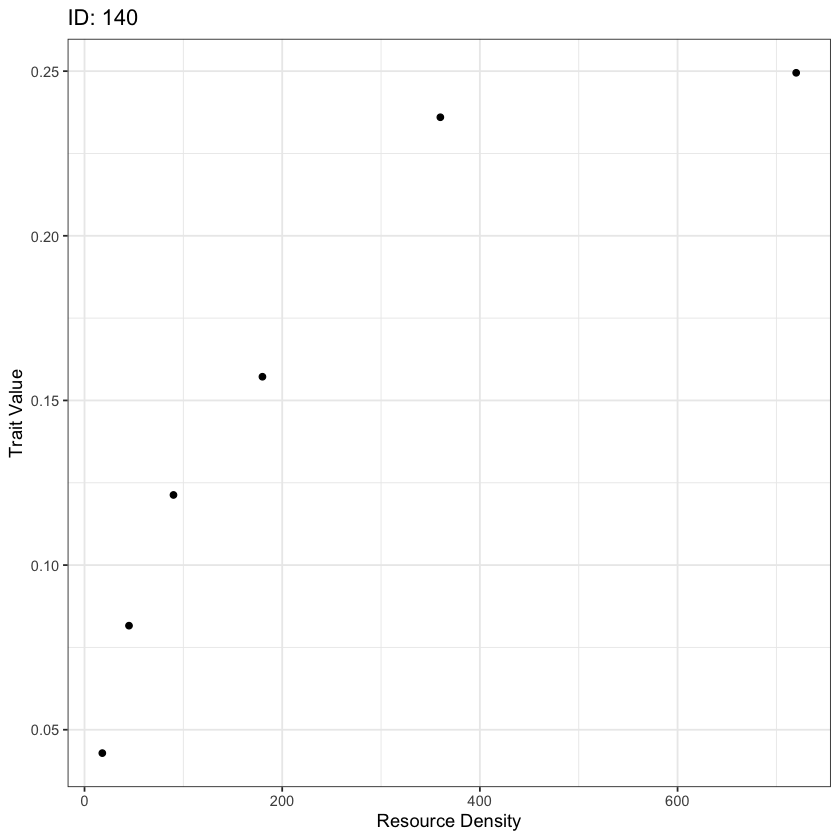

In [6]:
# Load data
frData <- read.csv('../Data/CRat_prepped.csv', stringsAsFactors = FALSE)

# Subset
id <- 140
df <- subset(frData, ID == id)

# Plot
ggplot(aes(x = ResDensity, y = N_TraitValue), data = df) +
        geom_point() + theme_bw() +
        ggtitle(paste("ID:", id)) +
        xlab("Resource Density") +
        ylab("Trait Value") 

#### Define models:

In [27]:
holling2 <- function(R, a, h){
    num <- a*R
    denom <- 1+a*h*R
    return(num/denom)
}

holling3 <- function(R, a, h, q){
  num <- a*R^(q+1)
  denom <- 1+a*h*R^(q+1)
  return(num/denom)
}

#### Estimate starting values
* a = gradient of linear part of curve
* h = 1/max(y)

#### Initial estimates:

In [22]:
######### h ##########
# As curve tends to 1/h (so would be 1/max(df$N_TraitValue)) but inverted once more to convert units from 1/s to s.
h <- max(df$N_TraitValue)

######### a ##########

# Subset the data 
BelowMean <- subset(df, N_TraitValue < mean(df$N_TraitValue))
BelowMax <- subset(df, N_TraitValue < max(df$N_TraitValue))
  
# Obtain summary stats of subsetted data
lmMean <- summary(lm(N_TraitValue ~ ResDensity, BelowMean))
lmMax <- summary(lm(N_TraitValue ~ ResDensity, BelowMax))
  
# Store the optimal attack rate as gradient of curve with highest R^2
#if (lmMean$r.squared >= lmMax$r.squared){
#    a <- coef(lmMean)[2]
#  } else {
#    a <- coef(lmMax)[2]
#}

# OR:
a <- ifelse(lmMean$r.squared >= lmMax$r.squared, coef(lmMean)[2], coef(lmMax)[2])

In [23]:
h
a

[1] 0.2495

[1] 0.0010678

### Optimise estimates:

#### Sampling methods

In [13]:
# for each random number distributed around a and h, use as param, fit, and extract lowest AIC


# What range should we sample over for each param? How can one be derived from the data? MUST BE A BETTER WAY HERE!
################################################
########### LATIN HYPERCUBE FAIL ###############
################################################
# suppressMessages(library(lhs))
#scale <- 5
# a
#a_lower <- a-scale*a
#a_upper <- a+scale*a
#a_diff <- a_upper - a_lower

#h_lower <- h-scale*h
#h_upper <- h+scale*h
#h_diff <- h_upper - h_lower


# Use Latin hypercube sampling for computational efficiency (100 samples 2 params - a and h)
#set.seed(1234)
#X <- randomLHS(100, 2)

#X[,1] <- a_lower + a_diff*X[,1] 
#X[,2] <- h_lower + h_diff*X[,2]
#################################################
set.seed(1234)
a_vals <- c(a, rnorm(100, a, a)) 
h_vals <- c(h, rnorm(100, h, h))

In [15]:
# preallocate vector of AIC values for combos
aics <- rep(NA, length(a_vals)**2) 

# Generate paramter combinations
paramCombos <- expand.grid(a = a_vals, h = h_vals)

# Add to it
for (i in 1:length(a_vals)**2){
    pair <- as.list(paramCombos[i,])
    a <- pair['a']
    h <- pair['h']
    
    suppressWarnings(
    Hol2Fit <- try(nlsLM(N_TraitValue ~ holling2(ResDensity, a, h), data = df, start = list(a = a, h = h)),
       silent = TRUE)
    )

    AIC <- ifelse(class(Hol2Fit) == "try-error", NA, AIC(Hol2Fit))
    
    aics[i] <- AIC
    
}

# Add to df
paramCombos$AIC <- aics

# Find minimum AIC
optimal_combo <- which.min(aics)

# Extract params
params <- paramCombos[optimal_combo,]

In [ ]:
aics <- rep(NA, length(a_vals)**2) 

In [188]:
#summary(lm(N_TraitValue~ResDensity, data = df[df$ResDensity<400,]))

In [189]:
#a <- 0.0005242

#### Fit models:

In [24]:
suppressMessages(library("minpack.lm")) # for Levenberg-Marquardt nlls fitting
suppressMessages(library(frair)) # for specialised functional resp fitting

# Test
#frair_test(formula = N_TraitValue~ResDensity, data = df)

# Fit
Hol2Fit <- nlsLM(N_TraitValue ~ holling2(ResDensity, a, h), data = df, start = list(a = a, h = h))
#Hol2Fit_Frair <- frair_fit(N_TraitValue~ResDensity, df, response='hollingsII', start=list(a=a, h=h), fixed=list(T=24/48))


# Summary
summary(Hol2Fit)

AIC(Hol2Fit)


Formula: N_TraitValue ~ holling2(ResDensity, a, h)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a 0.0022817  0.0002942   7.755  0.00149 ** 
h 3.3254445  0.2076481  16.015 8.89e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0124 on 4 degrees of freedom

Number of iterations to convergence: 7 
Achieved convergence tolerance: 1.49e-08


[1] -32.08797

In [13]:
# Coefficients
coef(Hol2Fit)

a           h 
0.002281671 3.325444541

Now let's plot the curve. For this we need x and y vectors:

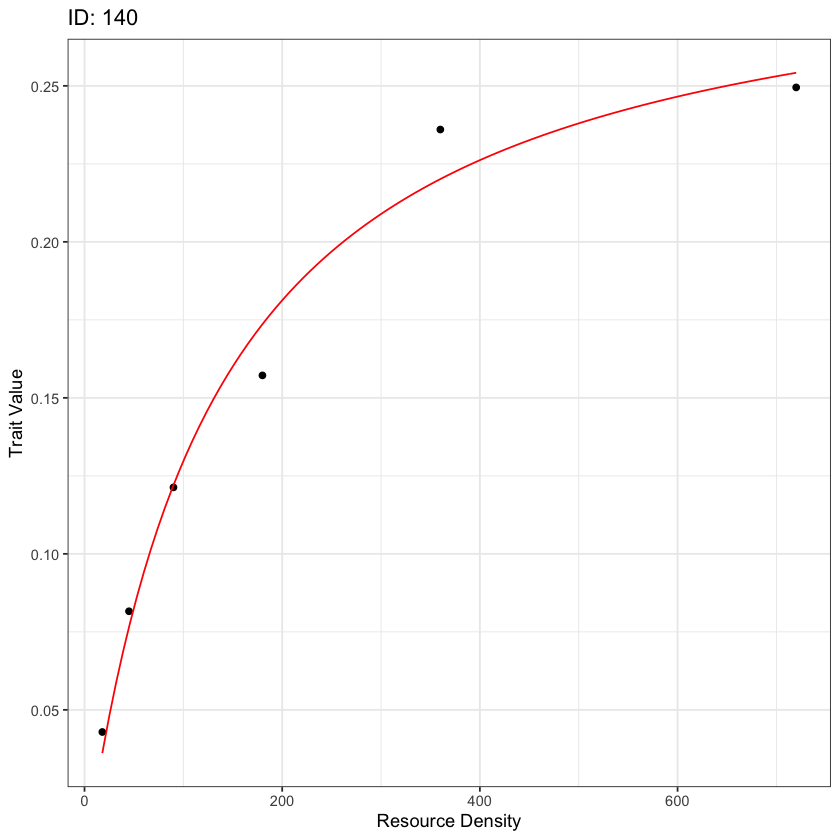

In [40]:
# x and y data
ResDensity <- df$ResDensity
N_TraitValue <- df$N_TraitValue

# Set x axis
x <- seq(from = min(ResDensity), to = max(ResDensity), by = ((max(ResDensity) - min(ResDensity))/100))

# Set predicted (y) values according to HollingII
y_holl2 <- holling2(x, coef(Hol2Fit)['a'], coef(Hol2Fit)['h'])

# Create dataframe of data to plot (x and y axes)
data_to_fit <- data.frame(x = x, y = y_holl2)

# Plot

ggplot(aes(x = ResDensity, y = N_TraitValue), data = df) +
        geom_point() + theme_bw() +
        geom_line(aes(x = x, y = y_holl2), data = data_to_fit, colour = 'red') +
        ggtitle(paste("ID:", id)) +
        xlab("Resource Density") +
        ylab("Trait Value") 

# O_o

In [196]:
a

[1] 0.0010678

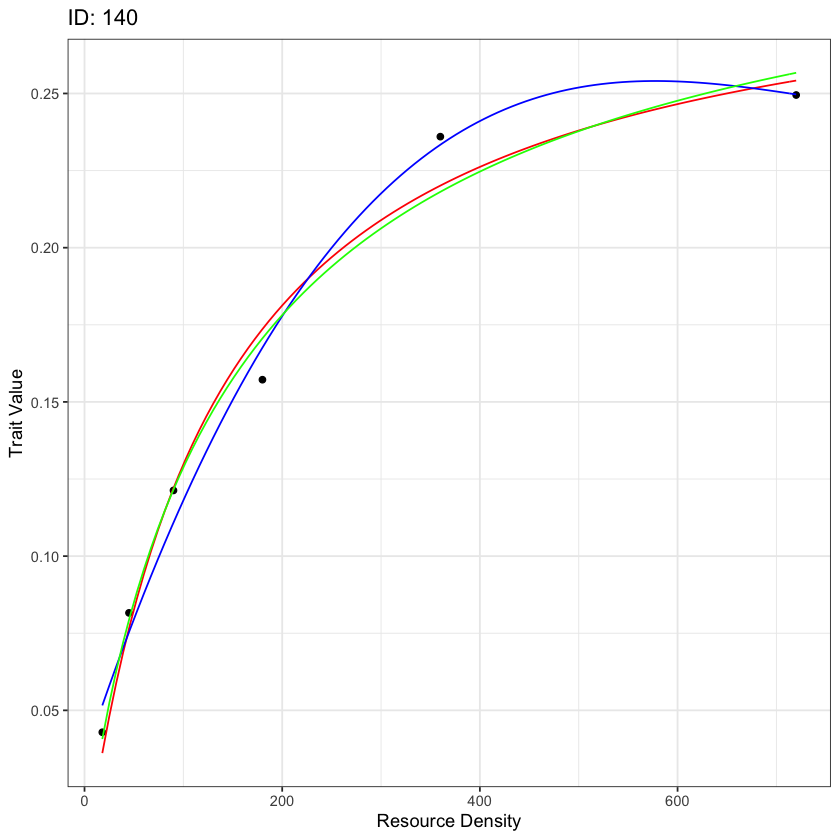

In [44]:
# Load data
Data <- read.csv('../Data/CRat_prepped.csv', stringsAsFactors = FALSE)
ModStats <- read.csv('../Data/STATS.csv', stringsAsFactors = FALSE)

# Subset
id <- 140
df <- subset(Data, ID == id)
stats <- subset(ModStats, ID == id)

# x and y data
ResDensity <- df$ResDensity
N_TraitValue <- df$N_TraitValue

##### MODELS #####
Cube <- lm(N_TraitValue ~ poly(ResDensity, 3))

# Set x axis
x <- seq(from = min(ResDensity), to = max(ResDensity), by = ((max(ResDensity) - min(ResDensity))/100))

# Set predicted (y) values according to HollingII
y_cube <- predict.lm(Cube, data.frame(ResDensity = x))
y_holl2 <- holling2(x, stats$a_Holl2, stats$h_Holl2)
y_holl3 <- holling3(x, stats$a_Holl3, stats$h_Holl3, stats$q_Holl3)

# Create dataframe of data to plot (x and y axes)
data_to_fit <- data.frame(x = x, y_cube = y_cube, y_holl2 = y_holl2, y_holl3 = y_holl3)

# Plot

ggplot(aes(x = ResDensity, y = N_TraitValue), data = df) +
        geom_point() + theme_bw() +
        geom_line(aes(x = x, y = y_holl2), data = data_to_fit, colour = 'red') +
        geom_line(aes(x = x, y = y_cube), data = data_to_fit, colour = 'blue') +
        geom_line(aes(x = x, y = y_holl3), data = data_to_fit, colour = 'green') +
        ggtitle(paste("ID:", id)) +
        xlab("Resource Density") +
        ylab("Trait Value")